[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vkhamesi/proteins/blob/main/main.ipynb)

In [1]:
import os

# Download the data
os.environ["KAGGLE_USERNAME"] = "parsaideh"
os.environ["KAGGLE_KEY"] = "KAGGLE_KEY"

! pip install transformers obonet biopython peft --quiet
! kaggle competitions download -c "cafa-5-protein-function-prediction"
! unzip cafa-5-protein-function-prediction.zip

import obonet
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import RocCurveDisplay, recall_score, precision_score, f1_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, logging
from peft import LoraConfig, get_peft_model

logging.set_verbosity_error()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.6 MB/s eta 0:00:00
 84% 97.0M/115M [00:00<00:00, 102MB/s]
100% 115M/115M [00:01<00:00, 119MB/s] 
Archive:  cafa-5-protein-function-prediction.zip

In [2]:
np.random.seed(42)
mlb = MultiLabelBinarizer()

# Mapping between proteins and gene ontology functions
train_terms = pd.read_csv("./Train/train_terms.tsv", sep="\t")
functions = train_terms.groupby("EntryID")["term"].apply(list)
functions_df = pd.DataFrame(mlb.fit_transform(functions), columns=mlb.classes_, index=functions.index)
functions_df = functions_df[functions_df.sum(axis=0).sort_values(ascending=False)[:1000].index]
functions_df = functions_df.loc[functions_df.sum(axis=1).sort_values(ascending=False)[:10000].index]
functions_df = functions_df[np.random.permutation(functions_df.columns)].sample(frac=1)
functions = functions_df.apply(lambda row: row.index[row == 1].tolist(), axis=1).to_dict()

# Description of each gene ontology function
go_graph = obonet.read_obo("./Train/go-basic.obo")
go_to_desc = {id_: (data.get("namespace") +
                    data.get("def")).replace("_", " ").replace('"', " ")
                    for id_, data in go_graph.nodes(data=True)}
go_to_desc = {k: go_to_desc[k] for k in functions_df.columns}

# Amino-acid sequence of each protein
protein_to_seq = SeqIO.to_dict(SeqIO.parse(open("./Train/train_sequences.fasta"), "fasta"))
protein_to_seq = {k: protein_to_seq[k] for k in functions_df.index}

In [3]:
class ProteinsDataset(Dataset):

    def __init__(self, protein_to_seq, go_to_desc, functions):

        self.protein_list = list(protein_to_seq.keys())
        self.protein_to_seq = protein_to_seq
        self.go_list = list(go_to_desc.keys())
        self.go_to_desc = go_to_desc
        self.functions = functions

        self.protein_tokenizer = AutoTokenizer.from_pretrained("yarongef/DistilProtBert")
        self.go_tokenizer = AutoTokenizer.from_pretrained("nlpie/distil-biobert")

    def __len__(self):
        return len(self.protein_to_seq) * len(self.go_to_desc)

    def __getitem__(self, idx):

        # Retrieve the protein sequence
        protein_idx = idx // len(self.go_to_desc)
        protein_name = self.protein_list[protein_idx]
        protein_sequence = " ".join(str(self.protein_to_seq[protein_name].seq))

        # Retrieve the gene ontology description
        go_idx = idx - protein_idx * len(self.go_to_desc)
        go_name = self.go_list[go_idx]
        go_description = self.go_to_desc[go_name]

        # Retrieve the label
        label = float(go_name in self.functions[protein_name])

        # Tokenize sequences
        protein_inputs = self.protein_tokenizer.encode_plus(
            protein_sequence, padding="max_length", max_length=1024,
            truncation=True, return_tensors="pt"
        )
        go_inputs = self.go_tokenizer.encode_plus(
            go_description, padding="max_length", max_length=256,
            truncation=True, return_tensors="pt"
        )

        protein_input_ids = protein_inputs["input_ids"].squeeze()
        protein_attention_mask = protein_inputs["attention_mask"].squeeze()
        go_input_ids = go_inputs["input_ids"].squeeze()
        go_attention_mask = go_inputs["attention_mask"].squeeze()

        return (protein_input_ids, protein_attention_mask,
                go_input_ids, go_attention_mask, label)

In [4]:
batch_size = 32

n_prot = 100
n_func = 100

train_dataset = ProteinsDataset(
    {k: protein_to_seq[k] for k in list(protein_to_seq)[:n_prot]},
    {k: go_to_desc[k] for k in list(go_to_desc)[:n_func]},
    functions
)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

n_prot_val = 20
n_func_val = 20

val_dataset = ProteinsDataset(
    {k: protein_to_seq[k] for k in list(protein_to_seq)[n_prot:n_prot+n_prot_val]},
    {k: go_to_desc[k] for k in list(go_to_desc)[n_func:n_func+n_func_val]},
    functions
)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/589 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [5]:
class ProteinPredictor(nn.Module):

    def __init__(self):
        super(ProteinPredictor, self).__init__()

        # Load the pre-trained models
        self.protein_model = AutoModel.from_pretrained("yarongef/DistilProtBert")
        self.go_model = AutoModel.from_pretrained("nlpie/distil-biobert")

        # Define linear layers for mapping embeddings to hidden dimensions
        self.protein_embedding_dim = self.protein_model.config.hidden_size
        self.go_embedding_dim = self.go_model.config.hidden_size

        # Reshape
        self.protein_reshape = nn.Linear(self.protein_embedding_dim, 256)
        self.go_reshape = nn.Linear(self.go_embedding_dim, 256)

        # Final MLP prediction
        self.mlp = nn.Sequential(
            nn.Linear(3 * 256, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def forward(self, protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask):

        # Generate protein embeddings
        protein_outputs = self.protein_model(input_ids=protein_input_ids,
                                             attention_mask=protein_attention_mask)
        # Average pooling
        protein_embeddings = protein_outputs.last_hidden_state.mean(dim=1)

        # Generate gene ontology embeddings
        go_outputs = self.go_model(input_ids=go_input_ids,
                                   attention_mask=go_attention_mask)
        # Average pooling
        go_embeddings = go_outputs.last_hidden_state.mean(dim=1)

        # Reshape
        protein_embeddings_reshaped = torch.tanh(self.protein_reshape(protein_embeddings))
        go_embeddings_reshaped = torch.tanh(self.go_reshape(go_embeddings))

        # Concatenate embeddings
        combined_embeddings = torch.cat((protein_embeddings_reshaped,
                                         go_embeddings_reshaped,
                                         torch.absolute(protein_embeddings_reshaped - go_embeddings_reshaped)), dim=1)

        # Last MLP pass for prediction
        output = self.mlp(combined_embeddings)

        return output

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = LoraConfig(
    r=8,
    lora_dropout=0.1,
    target_modules=[
        "go_model.encoder.layer.0.output.dense",
        "go_model.encoder.layer.3.output.dense",
        "go_model.encoder.layer.5.output.dense",
        "protein_model.encoder.layer.13.output.dense",
        "protein_model.encoder.layer.14.output.dense"],
    modules_to_save=[
        "protein_reshape",
        "go_reshape",
        "mlp.0",
        "mlp.2"]
)

model = ProteinPredictor()
peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()
model = peft_model.to(device)

pytorch_model.bin:   0%|          | 0.00/924M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/924M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/263M [00:00<?, ?B/s]

trainable params: 830,208 || all params: 298,257,409 || trainable%: 0.2784


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

In [7]:
weight = functions_df.iloc[:n_prot][functions_df.columns[:n_func]].mean().mean()
pos_weight = (1 - weight) / weight

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))
num_epochs = 3

In [9]:
scaler = torch.cuda.amp.GradScaler(enabled=True)
bar = trange(num_epochs)

loss_history = []
val_loss_history = []

for epoch in bar:

    # Training step
    model.train()
    for protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask, labels in train_dataloader:

        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=True):

            protein_input_ids = protein_input_ids.to(device)
            protein_attention_mask = protein_attention_mask.to(device)
            go_input_ids = go_input_ids.to(device)
            go_attention_mask = go_attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask)
            loss = criterion(outputs, labels.unsqueeze(1).float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        loss_history.append(loss.item())
        bar.set_postfix(loss=f"{np.mean(loss_history[-train_dataset.__len__()//batch_size:]):,.3f}")

    # Evaluation step
    model.eval()
    for protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask, labels in val_dataloader:

        val_loss = []

        with torch.no_grad():

            protein_input_ids = protein_input_ids.to(device)
            protein_attention_mask = protein_attention_mask.to(device)
            go_input_ids = go_input_ids.to(device)
            go_attention_mask = go_attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask)
            loss = criterion(outputs, labels.unsqueeze(1).float())

            val_loss.append(loss.item())

    val_loss_history.append(np.mean(val_loss))

<ipython-input-9-e1eae376e852>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)


  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
# Training data

model.eval()
y_pred = []
y_true = []

for i in tqdm(range(train_dataset.__len__() // 10)):

    with torch.no_grad():

        protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask, label = train_dataset.__getitem__(i)

        protein_input_ids = torch.reshape(protein_input_ids, (1, 1024)).to(device)
        protein_attention_mask = torch.reshape(protein_attention_mask, (1, 1024)).to(device)
        go_input_ids = torch.reshape(go_input_ids, (1, 256)).to(device)
        go_attention_mask = torch.reshape(go_attention_mask, (1, 256)).to(device)

        output = model(protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask)
        y_true.append(label)
        y_pred.append(torch.sigmoid(output).item())

  0%|          | 0/1000 [00:00<?, ?it/s]

Recall: 0.742
Precision: 0.272
F1-Score: 0.398


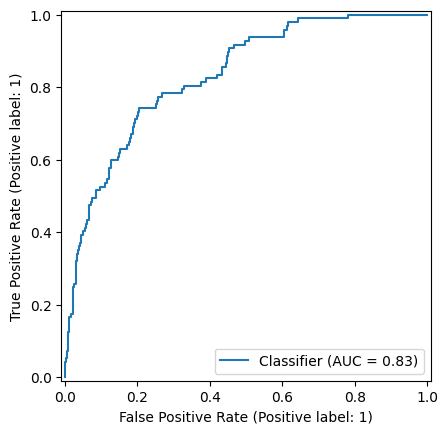

In [12]:
RocCurveDisplay.from_predictions(y_true, y_pred)
print(f"Recall: {recall_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")
print(f"Precision: {precision_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")
print(f"F1-Score: {f1_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")

In [13]:
# Seen proteins, unseen functions

test_dataset = ProteinsDataset({k: protein_to_seq[k] for k in list(protein_to_seq)[:100]},
                               {k: go_to_desc[k] for k in list(go_to_desc)[100:200]},
                               functions)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [14]:
model.eval()
y_pred = []
y_true = []

for i in tqdm(range(test_dataset.__len__() // 10)):

    with torch.no_grad():

        protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask, label = test_dataset.__getitem__(i)

        protein_input_ids = torch.reshape(protein_input_ids, (1, 1024)).to(device)
        protein_attention_mask = torch.reshape(protein_attention_mask, (1, 1024)).to(device)
        go_input_ids = torch.reshape(go_input_ids, (1, 256)).to(device)
        go_attention_mask = torch.reshape(go_attention_mask, (1, 256)).to(device)

        output = model(protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask)
        y_true.append(label)
        y_pred.append(torch.sigmoid(output).item())

  0%|          | 0/1000 [00:00<?, ?it/s]

Recall: 0.409
Precision: 0.113
F1-Score: 0.177


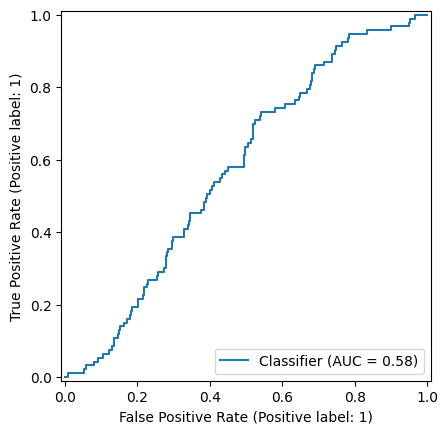

In [15]:
RocCurveDisplay.from_predictions(y_true, y_pred)
print(f"Recall: {recall_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")
print(f"Precision: {precision_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")
print(f"F1-Score: {f1_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")

In [16]:
# Unseen proteins, seen functions

test_dataset = ProteinsDataset({k: protein_to_seq[k] for k in list(protein_to_seq)[100:200]},
                               {k: go_to_desc[k] for k in list(go_to_desc)[:100]},
                               functions)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [17]:
model.eval()
y_pred = []
y_true = []

for i in tqdm(range(test_dataset.__len__() // 10)):

    with torch.no_grad():

        protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask, label = test_dataset.__getitem__(i)

        protein_input_ids = torch.reshape(protein_input_ids, (1, 1024)).to(device)
        protein_attention_mask = torch.reshape(protein_attention_mask, (1, 1024)).to(device)
        go_input_ids = torch.reshape(go_input_ids, (1, 256)).to(device)
        go_attention_mask = torch.reshape(go_attention_mask, (1, 256)).to(device)

        output = model(protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask)
        y_true.append(label)
        y_pred.append(torch.sigmoid(output).item())

  0%|          | 0/1000 [00:00<?, ?it/s]

Recall: 0.596
Precision: 0.230
F1-Score: 0.332


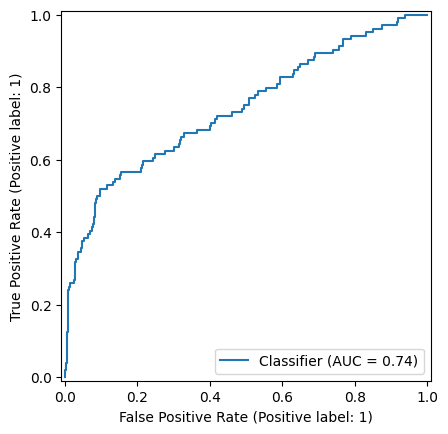

In [18]:
RocCurveDisplay.from_predictions(y_true, y_pred)
print(f"Recall: {recall_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")
print(f"Precision: {precision_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")
print(f"F1-Score: {f1_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")

In [ ]:
# Unseen proteins, unseen functions

test_dataset = ProteinsDataset({k: protein_to_seq[k] for k in list(protein_to_seq)[100:200]},
                               {k: go_to_desc[k] for k in list(go_to_desc)[100:200]},
                               functions)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [19]:
model.eval()
y_pred = []
y_true = []

for i in tqdm(range(test_dataset.__len__() // 10)):

    with torch.no_grad():

        protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask, label = test_dataset.__getitem__(i)

        protein_input_ids = torch.reshape(protein_input_ids, (1, 1024)).to(device)
        protein_attention_mask = torch.reshape(protein_attention_mask, (1, 1024)).to(device)
        go_input_ids = torch.reshape(go_input_ids, (1, 256)).to(device)
        go_attention_mask = torch.reshape(go_attention_mask, (1, 256)).to(device)

        output = model(protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask)
        y_true.append(label)
        y_pred.append(torch.sigmoid(output).item())

  0%|          | 0/1000 [00:00<?, ?it/s]

Recall: 0.596
Precision: 0.230
F1-Score: 0.332


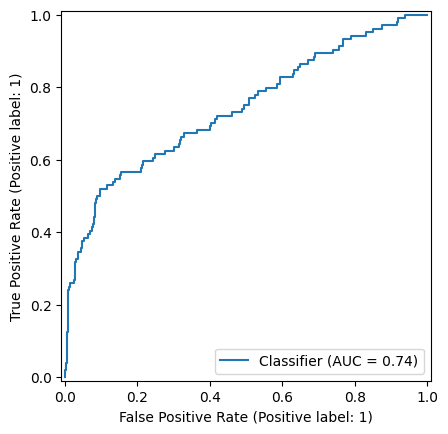

In [22]:
RocCurveDisplay.from_predictions(y_true, y_pred)
print(f"Recall: {recall_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")
print(f"Precision: {precision_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")
print(f"F1-Score: {f1_score(y_true, (np.asarray(y_pred) > 0.5).astype(int)):.3f}")

In [24]:
!pip install ipywidgets --quiet

In [33]:
import ipywidgets as widgets
from Bio import SeqIO
from IPython.display import display, clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

protein_tokenizer = AutoTokenizer.from_pretrained("yarongef/DistilProtBert")
go_tokenizer = AutoTokenizer.from_pretrained("nlpie/distil-biobert")

In [43]:
from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt

def preprocess_sequence(sequence):
    """
    If the input protein sequence does not have spaces between amino acids,
    this function inserts spaces between each amino acid.
    """
    # If there are no spaces, assume it's a raw sequence and add spaces.
    if " " not in sequence:
        sequence = " ".join(list(sequence.strip()))
    return sequence

def predict_protein_functions_interactive(sequence, num_functions=5):
    """
    Given a protein sequence, this function preprocesses the sequence, tokenizes it once,
    then iterates over a subset (num_functions) of GO descriptions from go_to_desc,
    and returns the predicted confidence score for each pairing.
    """
    # Preprocess the input sequence to match training format
    sequence = preprocess_sequence(sequence)

    # Tokenize the protein sequence once
    tokenized_prot = protein_tokenizer.encode_plus(
        sequence,
        padding="max_length",
        max_length=1024,
        truncation=True,
        return_tensors="pt"
    )
    protein_input_ids = tokenized_prot["input_ids"].to(device)
    protein_attention_mask = tokenized_prot["attention_mask"].to(device)

    # Select a subset of GO descriptions (using the first num_functions for now)
    go_desc_list = list(go_to_desc.values())[:num_functions]
    predictions = []

    for go_desc in go_desc_list:
        # Tokenize the GO description
        go_inputs = go_tokenizer.encode_plus(
            go_desc,
            padding="max_length",
            max_length=256,
            truncation=True,
            return_tensors="pt"
        )
        go_input_ids = go_inputs["input_ids"].to(device)
        go_attention_mask = go_inputs["attention_mask"].to(device)

        # Run inference with the trained model
        with torch.no_grad():
            output = model(protein_input_ids, protein_attention_mask, go_input_ids, go_attention_mask)
            score = torch.sigmoid(output).item()

        predictions.append({"go_desc": go_desc, "score": score})

    return predictions

def interactive_protein_prediction_cell():
    """
    Creates an interactive UI using ipywidgets where you can enter
    a protein sequence. On clicking the button, it predicts the confidence
    scores for a set of GO terms and displays them along with a bar chart.
    """
    # Create a text area for protein sequence input
    sequence_input = widgets.Textarea(
        placeholder="Enter a protein sequence (e.g., MKT... or M K T ...)",
        description="Protein:",
        layout=widgets.Layout(width="100%", height="100px")
    )

    # Create a button to trigger prediction
    predict_button = widgets.Button(description="Predict Functions")
    output_area = widgets.Output()

    def on_predict_clicked(b):
        with output_area:
            clear_output(wait=True)
            raw_sequence = sequence_input.value.strip()

            # Preprocessing is applied inside the prediction function
            print("Predicting functions for the input protein sequence...\n")

            print(raw_sequence)
            preds = predict_protein_functions_interactive(raw_sequence, num_functions=5)

            # Display each prediction (truncated for brevity)
            for i, pred in enumerate(preds):
                print(f"GO Term {i+1}: {pred['go_desc'][:800]}...  Confidence: {pred['score']:.3f}")

            # Plot the results as a bar chart
            plt.figure(figsize=(8,4))
            plt.bar([f"GO {i+1}" for i in range(len(preds))],
                    [pred["score"] for pred in preds],
                    color="blue", alpha=0.7)
            plt.xlabel("GO Terms (sampled)")
            plt.ylabel("Confidence Score")
            plt.title("Predicted Protein Functions")
            plt.ylim(0, 1)
            plt.show()

    predict_button.on_click(on_predict_clicked)

    display(sequence_input, predict_button, output_area)

# Run the interactive UI cell
interactive_protein_prediction_cell()


Textarea(value='', description='Protein:', layout=Layout(height='100px', width='100%'), placeholder='Enter a p…

Button(description='Predict Functions', style=ButtonStyle())

Output()